<a href="https://colab.research.google.com/github/gusgad/oil-price-by-sentiment-prediction/blob/main/oil_price_by_sentiment_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oil price by sentiment prediction
The goal of the experiment is to predict oil prices from sentiment on social media over the span of 18 years

In [ ]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from keras.wrappers.scikit_learn import KerasRegressor
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor


from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

print('Modules imported.')

Modules imported.


### Import and parse the dataset

In [ ]:
# reading in the dataset
df_sentiment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Oil price by sentiment prediction/data/com_enm_daily_filter_CRU.csv', on_bad_lines='skip', sep=';')
df_oil = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Oil price by sentiment prediction/data/daily_basket_trading_days.csv', on_bad_lines='skip', sep=';')

print('Import complete.')

Import complete.


### Explore the dataset

In [ ]:
# change pandas options to show more columns
pd.set_option("display.max.columns", None)
df_sentiment

,id,assetCode,windowTimestamp,dataType,systemVersion,mentions,buzz,sentiment,negative,positive,optimism,pessimism,joy,loveHate,trust,anger,disagreement,fear,gloom,stress,surprise,timeUrgency,uncertainty,violence,emotionVsFact,shortVsLongTerm,longShort,longShortForecast,priceDirection,priceDown,priceForecast,priceUp,topVsBottom,overvaluedVsUndervalued,volatility,consumptionVolume,productionVolume,regulatoryIssues,supplyVsDemand,supplyVsDemandForecast,newExploration,safetyAccident,futureVsPast,year
0,mp:1998-01-01_20.30.00.News.COM_ENM.CRU,CRU,1998/01/01 20:30:00,News,MP:4.0.0,20,"72,00","-0,041667","0,208333","0,166667","0,166667",NaN,NaN,NaN,"-0,013889",NaN,"-0,041667",NaN,"0,006944","0,041667","0,013889","0,020833","0,000000",NaN,"0,305556",NaN,"-0,013889",NaN,NaN,NaN,NaN,NaN,"0,041667",NaN,"0,013889",NaN,"0,013889",NaN,"0,104167","0,097222",NaN,NaN,"-0,069444",1998-01-01
1,mp:1998-01-01_20.30.00.News_Headline.COM_ENM.CRU,CRU,1998/01/01 20:30:00,News_Headline,MP:4.0.0,0,"0,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-01-01
2,mp:1998-01-01_20.30.00.News_Social.COM_ENM.CRU,CRU,1998/01/01 20:30:00,News_Social,MP:4.0.0,22,"96,00","-0,052083","0,197917","0,145833","0,125000",NaN,NaN,NaN,"-0,010417",NaN,"-0,010417",NaN,"0,005208","0,052083","0,010417","0,015625","0,000000",NaN,"0,187500","-0,041667","-0,093750","-0,083333",NaN,NaN,NaN,NaN,"0,010417",NaN,"0,010417",NaN,"0,010417",NaN,"0,078125","0,072917",NaN,NaN,"-0,031250",1998-01-01
3,mp:1998-01-01_20.30.00.Social.COM_ENM.CRU,CRU,1998/01/01 20:30:00,Social,MP:4.0.0,2,"24,00","-0,083333","0,166667","0,083333",NaN,NaN,NaN,NaN,NaN,NaN,"0,083333",NaN,NaN,"0,083333",NaN,NaN,NaN,NaN,"-0,166667","-0,166667","-0,333333","-0,333333",NaN,NaN,NaN,NaN,"-0,083333",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"0,083333",1998-01-01
4,mp:1998-01-02_20.30.00.News.COM_ENM.CRU,CRU,1998/01/02 20:30:00,News,MP:4.0.0,8,"44,00","0,011364","0,261364","0,272727",NaN,"0,113636",NaN,"0,022727",NaN,"0,011364","0,045455",NaN,NaN,"0,045455",NaN,NaN,NaN,"0,022727","0,409091","-0,022727",NaN,NaN,NaN,NaN,NaN,NaN,"-0,022727",NaN,"0,045455",NaN,NaN,NaN,"-0,113636","-0,045455",NaN,NaN,"-0,522727",1998-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,mp:2021-12-30_20.30.00.Social.COM_ENM.CRU,CRU,2021/12/30 20:30:00,Social,MP:4.0.11,1939,"1381,70","-0,030035","0,218933","0,188898","0,064413","0,049577","0,005066","0,002895","0,022798","0,003257","0,005790","0,004342","0,030035","0,045958","0,006514","-0,023884","0,028371","0,005790","0,453934","-0,008685","-0,005790","0,000724","0,005066","0,002171","0,001447","0,007237","0,005790","-0,001447","0,018094","-0,000362","0,003619",NaN,"-0,003257","0,004704","0,001447",NaN,"-0,184591",2021-12-30
35060,mp:2021-12-31_20.30.00.News.COM_ENM.CRU,CRU,2021/12/31 20:30:00,News,MP:4.0.11,4217,"15563,40","0,000514","0,245191","0,245705","0,049025","0,086678","0,001285","0,000675","0,015100","0,000739","0,014296","0,012690","0,023356","0,050471","0,006072","-0,003148","0,011167","0,006457","0,460041","-0,033637","-0,002474","-0,000129","-0,003020","0,006779","-0,000353","0,003759","-0,002570","-0,000064","0,026601","0,000643","-0,003373",NaN,"-0,006425","0,008449","0,000578",NaN,"-0,278281",2021-12-31
35061,mp:2021-12-31_20.30.00.News_Headline.COM_ENM.CRU,CRU,2021/12/31 20:30:00,News_Headline,MP:4.0.11,234,"458,50","-0,037077","0,260632","0,223555","0,054526","0,047983",NaN,NaN,"0,006543","0,001091","-0,015267","0,087241","0,017448","0,041439","0,010905","-0,002181",NaN,"0,006543","0,338059","0,004362","-0,002181",NaN,"-0,004362","0,008724",NaN,"0,004362","-0,030534",NaN,"0,049073",NaN,"0,006543",NaN,"-0,062159","-0,002181",NaN,NaN,"-0,051254",2021-12-31
35062,mp:2021-12-31_20.30.00.News_Social.COM_ENM.CRU,CRU,2021/12/31 20:30:00,News_Social,MP:

In [ ]:
df_oil.drop(index=df_oil.index[0], 
        axis=0, 
        inplace=True)
df_oil = df_oil.rename(columns={'" encoding': 'date', '" ?>': "price"})
df_oil

,date,price
1,02.01.03,"30,05"
2,03.01.03,"30,83"
3,06.01.03,"30,71"
4,07.01.03,"29,72"
5,08.01.03,"28,86"
...,...,...
4886,13.12.21,"75,04"
4887,14.12.21,"74,28"
4888,15.12.21,"73,12"
4889,16.12.21,"74,66"


In [ ]:
print('Sentiment dataset shape:', df_sentiment.shape)
print('Oil price dataset shape:', df_oil.shape)

Sentiment dataset shape: (35064, 44)
Oil price dataset shape: (4890, 2)


In [ ]:
# filter by 'Social' dataType
df_sentiment = df_sentiment.loc[df_sentiment['dataType'] == 'Social']

# remove unnecessary columns
df_sentiment = df_sentiment.drop('id', 1)
df_sentiment = df_sentiment.drop('windowTimestamp', 1)
df_sentiment = df_sentiment.drop('assetCode', 1)
df_sentiment = df_sentiment.drop('systemVersion', 1)
df_sentiment = df_sentiment.rename(columns={'year': 'date'})

In [ ]:
# replace ',' with '.' and convert strings to floats
df_sentiment['buzz'] = df_sentiment['buzz'].str.replace(",",".").astype(float)
df_sentiment['sentiment'] = df_sentiment['sentiment'].str.replace(",",".").astype(float)
df_sentiment['negative'] = df_sentiment['negative'].str.replace(",",".").astype(float)
df_sentiment['positive'] = df_sentiment['positive'].str.replace(",",".").astype(float)
df_sentiment['optimism'] = df_sentiment['optimism'].str.replace(",",".").astype(float)
df_sentiment['pessimism'] = df_sentiment['pessimism'].str.replace(",",".").astype(float)
df_sentiment['joy'] = df_sentiment['joy'].str.replace(",",".").astype(float)
df_sentiment['loveHate'] = df_sentiment['loveHate'].str.replace(",",".").astype(float)
df_sentiment['trust'] = df_sentiment['trust'].str.replace(",",".").astype(float)
df_sentiment['anger'] = df_sentiment['anger'].str.replace(",",".").astype(float)
df_sentiment['disagreement'] = df_sentiment['disagreement'].str.replace(",",".").astype(float)
df_sentiment['fear'] = df_sentiment['fear'].str.replace(",",".").astype(float)
df_sentiment['gloom'] = df_sentiment['gloom'].str.replace(",",".").astype(float)
df_sentiment['stress'] = df_sentiment['stress'].str.replace(",",".").astype(float)
df_sentiment['surprise'] = df_sentiment['surprise'].str.replace(",",".").astype(float)
df_sentiment['timeUrgency'] = df_sentiment['timeUrgency'].str.replace(",",".").astype(float)
df_sentiment['uncertainty'] = df_sentiment['uncertainty'].str.replace(",",".").astype(float)
df_sentiment['violence'] = df_sentiment['violence'].str.replace(",",".").astype(float)
df_sentiment['emotionVsFact'] = df_sentiment['emotionVsFact'].str.replace(",",".").astype(float)
df_sentiment['shortVsLongTerm'] = df_sentiment['shortVsLongTerm'].str.replace(",",".").astype(float)
df_sentiment['longShort'] = df_sentiment['longShort'].str.replace(",",".").astype(float)
df_sentiment['longShortForecast'] = df_sentiment['longShortForecast'].str.replace(",",".").astype(float)
df_sentiment['priceDirection'] = df_sentiment['priceDirection'].str.replace(",",".").astype(float)
df_sentiment['priceDown'] = df_sentiment['priceDown'].str.replace(",",".").astype(float)
df_sentiment['priceForecast'] = df_sentiment['priceForecast'].str.replace(",",".").astype(float)
df_sentiment['priceUp'] = df_sentiment['priceUp'].str.replace(",",".").astype(float)
df_sentiment['topVsBottom'] = df_sentiment['topVsBottom'].str.replace(",",".").astype(float)
df_sentiment['overvaluedVsUndervalued'] = df_sentiment['overvaluedVsUndervalued'].str.replace(",",".").astype(float)
df_sentiment['volatility'] = df_sentiment['volatility'].str.replace(",",".").astype(float)
df_sentiment['consumptionVolume'] = df_sentiment['consumptionVolume'].str.replace(",",".").astype(float)
df_sentiment['productionVolume'] = df_sentiment['productionVolume'].str.replace(",",".").astype(float)
df_sentiment['regulatoryIssues'] = df_sentiment['regulatoryIssues'].str.replace(",",".").astype(float)
df_sentiment['supplyVsDemand'] = df_sentiment['supplyVsDemand'].str.replace(",",".").astype(float)
df_sentiment['futureVsPast'] = df_sentiment['futureVsPast'].str.replace(",",".").astype(float)
df_sentiment['newExploration'] = df_sentiment['newExploration'].str.replace(",",".").astype(float)
df_sentiment['safetyAccident'] = df_sentiment['safetyAccident'].str.replace(",",".").astype(float)
df_sentiment['date'] =  pd.to_datetime(df_sentiment['date'])

df_oil['price'] = df_oil['price'].str.replace(",",".").astype(float)
df_oil['date'] =  pd.to_datetime(df_oil['date'])

# fill NAN values with the column mean
df_sentiment.fillna(df_sentiment.mean(), inplace=True)
df_oil.fillna(df_oil.mean(), inplace=True)

In [ ]:
df_sentiment

,dataType,mentions,buzz,sentiment,negative,positive,optimism,pessimism,joy,loveHate,trust,anger,disagreement,fear,gloom,stress,surprise,timeUrgency,uncertainty,violence,emotionVsFact,shortVsLongTerm,longShort,longShortForecast,priceDirection,priceDown,priceForecast,priceUp,topVsBottom,overvaluedVsUndervalued,volatility,consumptionVolume,productionVolume,regulatoryIssues,supplyVsDemand,supplyVsDemandForecast,newExploration,safetyAccident,futureVsPast,date
3,Social,2,24.00,-0.083333,0.166667,0.083333,0.071912,0.072151,0.005513,0.002939,0.012612,0.004812,0.083333,0.006139,0.034131,0.083333,0.006414,-0.000632,0.024797,0.010917,-0.166667,-0.166667,-0.333333,-0.333333,0.000870,0.001477,0.000446,0.002248,-0.083333,-0.001311,0.019381,0.000711,-0.001111,0.000778,0.007466,NaN,0.002902,0.002091,0.083333,1998-01-01
7,Social,17,137.40,0.087336,0.160116,0.247453,0.101892,0.029112,0.005513,0.002939,0.012612,0.004812,-0.050946,0.006139,0.007278,0.065502,0.065502,0.152838,0.039301,0.010917,0.272198,-0.014556,-0.005385,-0.001296,0.000000,0.021834,-0.021834,0.021834,-0.029112,-0.029112,0.019381,0.000711,-0.001111,0.000778,0.007466,NaN,0.002902,0.002091,0.203785,1998-01-02
11,Social,25,401.50,0.200498,0.159402,0.359900,0.104608,0.084682,0.012453,0.011208,0.064757,0.004981,0.017435,-0.002491,0.009963,0.029888,0.004981,-0.012453,0.041096,0.004981,0.429639,-0.034869,0.019925,-0.004981,0.009963,0.001477,0.009963,0.009963,-0.014944,-0.004981,0.004981,0.002491,0.004981,0.000778,-0.009963,"0,000000",0.004981,0.002091,0.373599,1998-01-03
15,Social,16,110.00,0.145455,0.200000,0.345455,0.145455,0.100000,0.005513,0.002939,0.012612,0.004812,-0.004545,0.006139,0.022727,0.022727,0.006414,-0.022727,0.018182,0.010917,0.272727,0.009091,-0.040909,-0.018182,-0.009091,0.018182,-0.018182,0.009091,-0.018182,-0.001311,0.027273,0.000711,-0.001111,0.000778,0.018182,NaN,0.002902,0.002091,0.140909,1998-01-04
19,Social,13,113.00,0.252212,0.110619,0.362832,0.159292,0.017699,0.017699,0.002939,0.039823,0.004425,-0.035398,0.006139,0.008850,0.022124,0.013274,-0.048673,0.008850,0.010917,0.438053,-0.070796,0.026549,0.000000,0.000870,0.001477,0.000446,0.002248,-0.001623,-0.001311,0.013274,0.000711,-0.001111,0.000778,0.007466,NaN,0.002902,0.002091,0.026549,1998-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35047,Social,1765,1034.40,-0.027552,0.210267,0.182715,0.073473,0.065739,0.008701,0.004350,0.000967,0.006767,0.008217,0.007734,0.015951,0.039153,0.006767,-0.008217,0.011504,0.015468,0.281806,0.031903,0.007251,-0.002417,0.000967,0.001933,-0.000967,0.002900,-0.001450,0.001933,0.028519,0.000711,0.000967,0.000778,0.018368,"-0,001933",0.002902,0.002091,0.049787,2021-12-27
35048,Social,1767,1754.30,0.064128,0.199795,0.263923,0.056718,0.066693,0.006840,0.004275,0.010261,0.002850,0.009120,0.007695,0.034772,0.039617,0.001425,-0.011971,0.020977,0.004845,0.444793,0.005130,-0.013966,-0.002850,0.006270,0.001140,0.000446,0.007410,-0.014536,-0.000855,0.016531,0.000711,-0.000855,0.000778,-0.005415,"-0,001995",0.001140,0.002091,-0.066465,2021-12-28
35055,Social,2283,2086.55,0.066857,0.180441,0.247298,0.080516,0.043613,0.008147,0.002636,0.023963,0.002396,0.001198,0.006710,0.020608,0.033548,0.004793,-0.002157,0.018260,0.003834,0.332031,-0.016534,-0.009106,0.004793,0.006949,0.000240,0.000446,0.007189,-0.001677,-0.000719,0.035825,0.000479,0.001438,0.000778,-0.002157,"0,000959",0.000479,0.002091,-0.096715,2021-12-29
35059,Social,1939,1381.70,-0.030035,0.218933,0.188898,0.064413,0.049577,0.005066,0.002895,0.022798,0.003257,0.005790,0.004342,0.030035,0.045958,0.006514,-0.023884,0.028371,0.005790,0.453934,-0.008685,-0.005790,0.000724,0.005066,0.002171,0.001447,0.007237,0.005790,-0.001447,0.018094,-0.000362,0.003619,0.000778,-0.003257,"0,004704",0.001447,0.002091,-0.184591,2021-12-30


In [ ]:
df_oil

,date,price
1,2003-02-01,30.05
2,2003-03-01,30.83
3,2003-06-01,30.71
4,2003-07-01,29.72
5,2003-08-01,28.86
...,...,...
4886,2021-12-13,75.04
4887,2021-12-14,74.28
4888,2021-12-15,73.12
4889,2021-12-16,74.66


In [ ]:
df = pd.merge(df_oil, df_sentiment, on='date', how='left')
df

,date,price,dataType,mentions,buzz,sentiment,negative,positive,optimism,pessimism,joy,loveHate,trust,anger,disagreement,fear,gloom,stress,surprise,timeUrgency,uncertainty,violence,emotionVsFact,shortVsLongTerm,longShort,longShortForecast,priceDirection,priceDown,priceForecast,priceUp,topVsBottom,overvaluedVsUndervalued,volatility,consumptionVolume,productionVolume,regulatoryIssues,supplyVsDemand,supplyVsDemandForecast,newExploration,safetyAccident,futureVsPast
0,2003-02-01,30.05,Social,40,203.50,-0.071253,0.240786,0.169533,0.041769,0.058968,-0.002457,0.002939,0.031941,0.004812,0.039312,0.004914,0.049140,0.046683,0.009828,0.012285,0.014742,0.034398,0.425061,0.014742,-0.051597,-0.034398,0.000870,0.001477,0.000446,0.002248,0.014742,-0.001311,0.009828,0.000711,-0.002457,0.000778,-0.034398,"-0,022113",0.019656,0.002091,-0.115479
1,2003-03-01,30.83,Social,78,615.20,-0.086151,0.247074,0.160923,0.052016,0.093466,0.005513,0.002438,0.004064,0.005689,0.009753,0.024382,0.053641,0.056079,0.013817,0.034135,0.006014,0.008940,0.361996,-0.003251,-0.021944,-0.011378,-0.004876,0.004876,-0.001625,0.002248,-0.001625,-0.000813,0.031697,0.000711,0.006502,0.000778,-0.003251,"0,000000",0.001625,0.002091,-0.024870
2,2003-06-01,30.71,Social,9,97.50,0.030769,0.194872,0.225641,0.123077,0.092308,0.020513,0.020513,0.010256,0.010256,-0.020513,0.006139,0.030769,0.030769,0.020513,0.020513,0.112821,0.015385,0.415385,-0.071795,0.010256,-0.001296,0.000870,0.001477,0.000446,0.002248,0.025641,-0.001311,0.046154,0.000711,-0.001111,0.000778,0.010256,NaN,0.002902,0.002091,0.328205
3,2003-07-01,29.72,Social,43,353.00,-0.033994,0.256374,0.222380,0.046742,0.164306,0.001416,0.008499,0.028329,0.004812,0.038244,0.008499,0.033994,0.072238,0.016997,-0.007082,0.014164,0.014164,0.616147,0.014164,-0.005666,-0.002833,0.000870,0.001477,0.000446,0.002248,-0.002833,0.005666,0.004249,0.000711,0.002833,0.000778,-0.004249,"-0,002833",0.002902,0.002091,-0.032578
4,2003-08-01,28.86,Social,38,231.95,0.137961,0.163828,0.301789,0.051735,0.012934,0.017245,0.000000,-0.012934,0.025868,-0.002156,0.004311,0.021556,0.045268,0.004311,-0.004311,0.052598,0.010917,0.504203,0.012934,0.019401,0.004311,0.004311,0.001477,0.000446,0.004311,0.004311,-0.001311,0.016167,0.000711,0.008623,0.000778,0.025868,NaN,0.004311,0.002091,-0.254581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4885,2021-12-13,75.04,Social,1554,2092.10,-0.000239,0.216051,0.215812,0.066679,0.058076,0.008843,0.002629,0.027245,0.003824,0.001195,0.007887,0.030591,0.043736,0.008843,0.008365,0.030543,0.007170,0.451747,0.000717,-0.009560,-0.002629,-0.001673,0.002629,0.000446,0.000956,0.009560,0.000717,0.018642,0.000711,0.001195,0.000778,-0.001195,"-0,006214",0.002902,0.002091,-0.023087
4886,2021-12-14,74.28,Social,1959,2090.20,-0.040188,0.205004,0.164817,0.065783,0.064826,0.006698,0.001196,0.001674,0.007655,0.002392,0.006220,0.034446,0.038991,0.005502,-0.006220,0.012774,0.009808,0.286193,-0.033729,-0.005023,0.000957,-0.001914,0.002871,0.000446,0.000957,0.005023,0.002631,0.023682,0.000711,0.003827,0.000778,0.044015,"0,023204",0.000478,0.002091,-0.081715
4887,2021-12-15,73.12,Social,2267,2475.25,-0.023028,0.204424,0.181396,0.070296,0.067670,0.001616,0.002828,0.009696,0.005656,0.014746,0.007878,0.029088,0.042218,0.005656,0.000202,0.019917,0.008686,0.345581,-0.023634,-0.005454,-0.002020,0.001212,0.000808,0.000446,0.002020,0.000000,0.001616,0.024341,0.000711,0.001212,0.000778,0.002626,"0,009696",0.000808,0.002091,0.005838
4888,2021-12-16,74.66,Social,1946,1925.80,0.007270,0.208744,0.216014,0.061273,0.054004,0.011683,0.004414,0.004154,0.007270,0.005193,0.003635,0.027261,0.037906,0.005712,0.000000,0.024302,0.008308,0.390643,0.004673,0.009606,0.002077,0.001558,0.001477,0.000519,0.001558,-0.002856,-0.002337,0.018953,-0.000519,-0.001298,0.000778,-0.005972,"0,000519",0.001817,0.002091,-0.113771


In [ ]:
# take a deper look into the dataset
df.describe()

,price,mentions,buzz,sentiment,negative,positive,optimism,pessimism,joy,loveHate,trust,anger,disagreement,fear,gloom,stress,surprise,timeUrgency,uncertainty,violence,emotionVsFact,shortVsLongTerm,longShort,longShortForecast,priceDirection,priceDown,priceForecast,priceUp,topVsBottom,overvaluedVsUndervalued,volatility,consumptionVolume,productionVolume,regulatoryIssues,supplyVsDemand,newExploration,safetyAccident,futureVsPast
count,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000
mean,67.582546,1373.675051,2884.305654,-0.003774,0.225995,0.222221,0.069284,0.071318,0.005223,0.002652,0.012132,0.004328,0.010142,0.005853,0.033405,0.048065,0.006115,-0.000245,0.024145,0.010254,0.424242,-0.006320,-0.005965,-0.001214,0.000735,0.001372,0.000370,0.002033,-0.000583,-0.001079,0.019684,0.000675,-0.000788,0.000772,0.008807,0.002577,0.001955,-0.072405
std,26.496657,1703.775341,2884.572784,0.069493,0.034004,0.040532,0.020576,0.020498,0.002736,0.002378,0.011011,0.002692,0.011810,0.003210,0.011118,0.009849,0.003315,0.010162,0.008965,0.005902,0.053229,0.011580,0.009871,0.004287,0.002111,0.001021,0.000935,0.001629,0.007857,0.002727,0.006610,0.001420,0.004889,0.000410,0.017796,0.002213,0.001806,0.089448
min,12.220000,4.000000,26.500000,-0.398230,0.071429,0.035398,0.000000,-0.005076,-0.002609,-0.010676,-0.050465,-0.003922,-0.055959,-0.004357,-0.005362,0.010152,-0.004942,-0.076433,-0.032967,-0.002083,-0.023585,-0.112214,-0.188679,-0.087912,-0.012591,-0.001585,-0.008282,-0.001821,-0.047170,-0.037736,-0.001844,-0.008586,-0.030243,-0.000637,-0.100183,-0.004149,-0.002433,-0.402733
25%,47.297500,200.000000,1113.612500,-0.048965,0.203251,0.195358,0.055948,0.057996,0.003371,0.001361,0.005935,0.002594,0.003703,0.003695,0.025807,0.042045,0.004106,-0.006111,0.018848,0.006755,0.393094,-0.012559,-0.010762,-0.002851,-0.000320,0.000744,0.000059,0.001029,-0.005657,-0.002221,0.015586,0.000059,-0.003176,0.000778,-0.001715,0.001258,0.001131,-0.131107
50%,63.700000,554.500000,2241.625000,-0.006331,0.224836,0.219270,0.066660,0.069613,0.004930,0.002396,0.011650,0.003866,0.010271,0.005343,0.032685,0.048108,0.005687,-0.000250,0.023284,0.008996,0.426114,-0.005462,-0.005454,-0.001062,0.000746,0.001426,0.000446,0.001889,-0.001037,-0.001156,0.019272,0.000711,-0.000699,0.000778,0.008168,0.002230,0.002091,-0.081223
75%,85.885000,2345.500000,3598.675000,0.040493,0.247475,0.246389,0.079265,0.082536,0.006507,0.003537,0.017586,0.005360,0.016471,0.007337,0.040037,0.054029,0.007524,0.005597,0.028197,0.012247,0.458076,0.000857,-0.000735,0.000750,0.001545,0.001477,0.000456,0.002278,0.003940,0.000000,0.023181,0.000816,0.001859,0.000778,0.019029,0.002942,0.002091,-0.019133
max,140.700000,24162.000000,44411.800000,0.381038,0.433628,0.462433,0.302752,0.283186,0.031153,0.037736,0.114650,0.031746,0.100346,0.032017,0.110307,0.100241,0.040000,0.065421,0.112821,0.074310,0.656904,0.074766,0.078947,0.052632,0.029011,0.014577,0.020619,0.029852,0.062201,0.043956,0.080459,0.021978,0.036765,0.022483,0.123278,0.052910,0.031575,0.571865


### Plot some features

In [ ]:
df_weekly = df.resample('W', on='date').mean()
df_monthly = df.resample('M', on='date').mean()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Ölpreis')

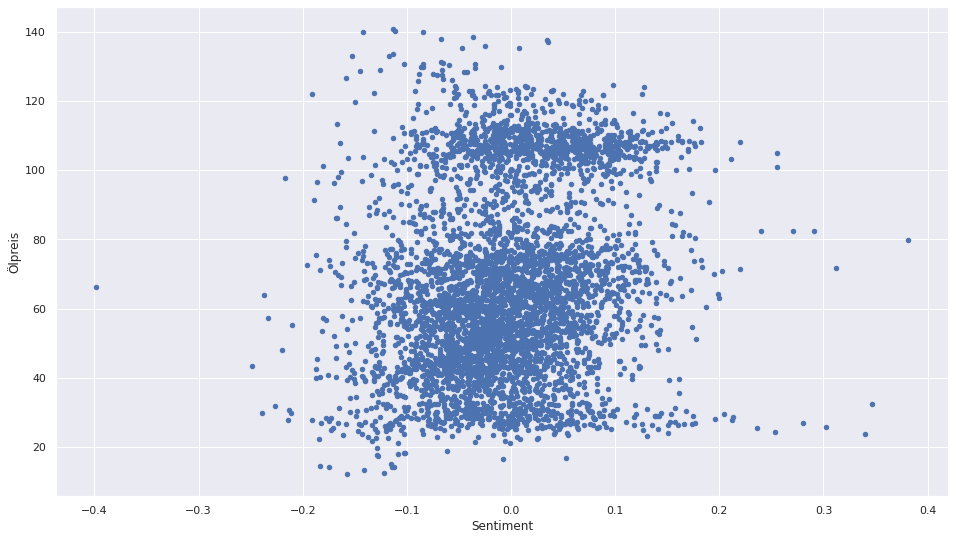

In [ ]:
df.plot.scatter(x='sentiment',y='price',  figsize=(16,9))
plt.xlabel('Sentiment')
plt.ylabel('Ölpreis')

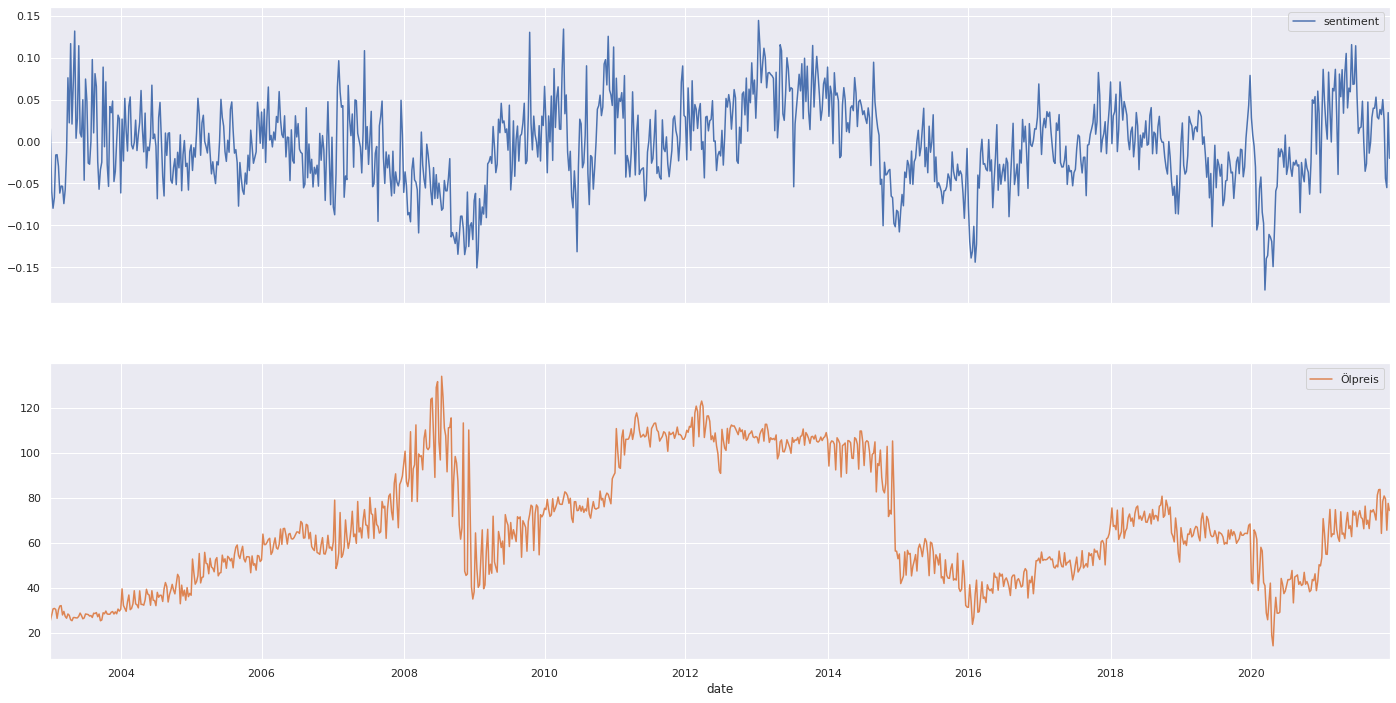

In [ ]:
# taegliche veraenderung von oelpreis und sentiment
df_weekly[['sentiment', 'price']].plot(subplots=True, figsize=(24, 12))
plt.legend(labels=['Ölpreis'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Buzz')

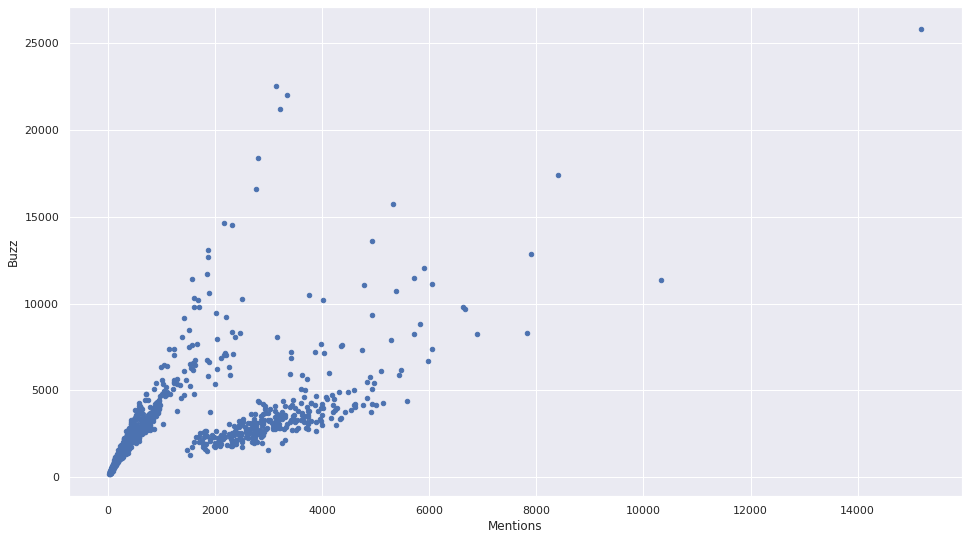

In [ ]:
# mentions and buzz
df_weekly.plot.scatter(x='mentions',y='buzz',  figsize=(16,9))
plt.xlabel('Mentions')
plt.ylabel('Buzz')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33a3dcc150>,
      dtype=object)

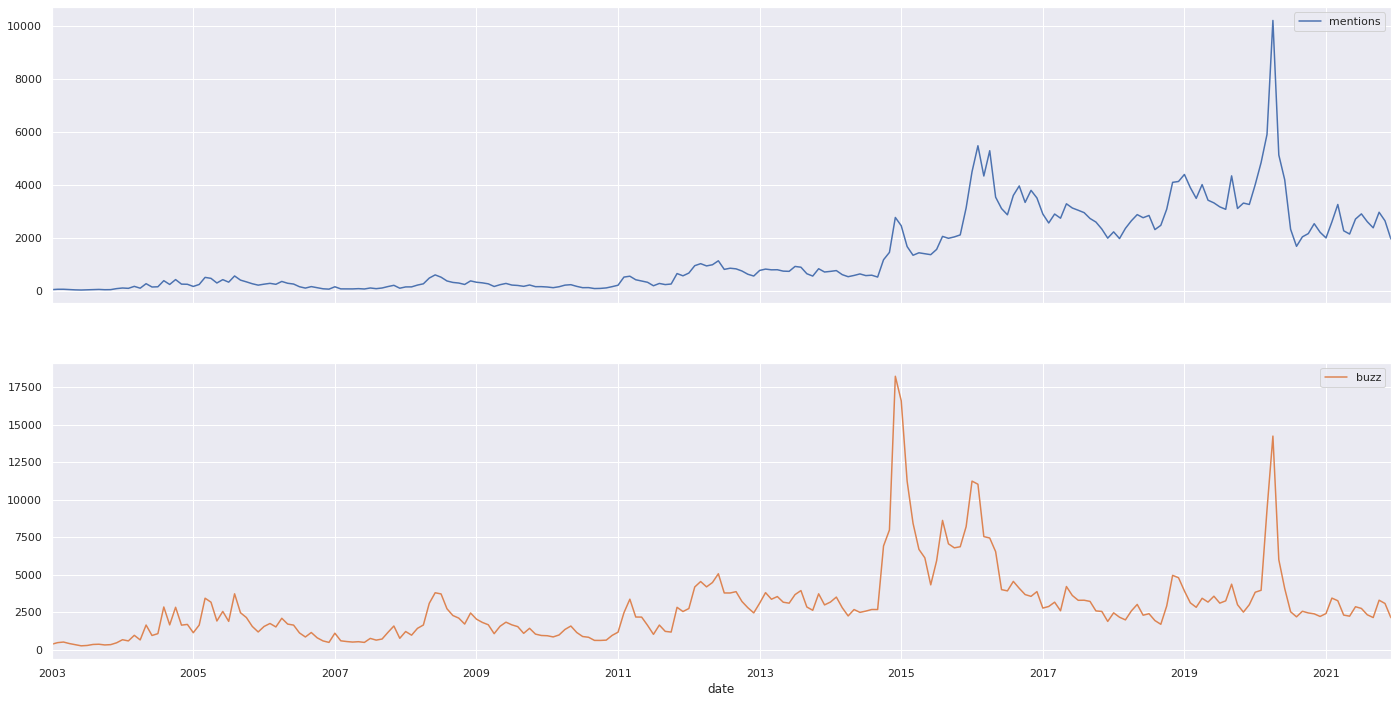

In [ ]:
# taegliche veraenderung von mentions und buzz
df_monthly[['mentions', 'buzz']].plot(subplots=True, figsize=(24, 12))

Text(0, 0.5, 'Ölpreis')

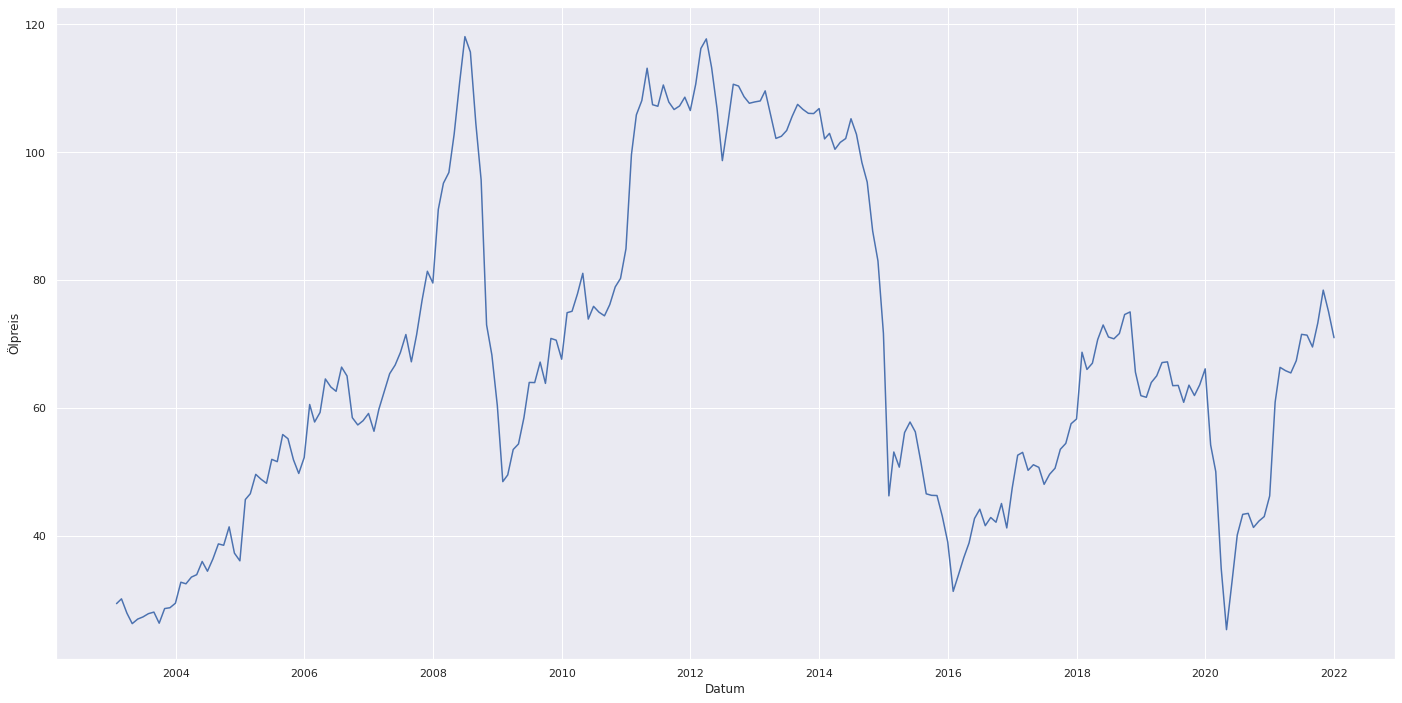

In [ ]:
# oelpreise von 2003 bis 2021
plt.figure(figsize=(24, 12))
sns.lineplot(data=df_monthly, x='date', y='price')
plt.xlabel('Datum')
plt.ylabel('Ölpreis')

Text(0.5, 0, 'Datum')

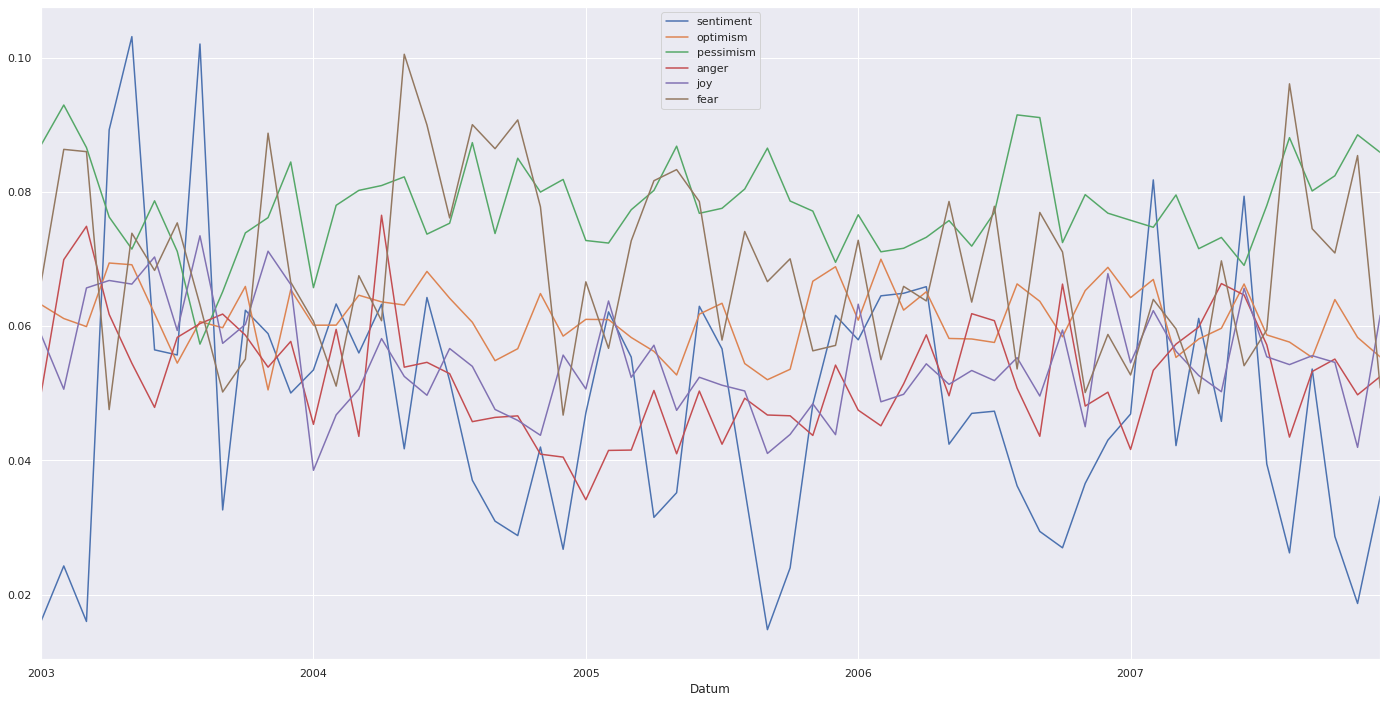

In [ ]:
# sentiment, optimism, pessimism, anger, joy, fear (2003-2007)
start_day = '01.01.2003'
end_day = '31.12.2007'

# Convert start / end dates to datetime
start_day = pd.to_datetime(start_day)
end_day = pd.to_datetime(end_day)

df_monthly_2003_2007 = df.loc[(df['date'] > start_day) & (df['date'] <= end_day)]
df_monthly_2003_2007 = df_monthly_2003_2007.resample('M', on='date').mean()
df_monthly_2003_2007 = df_monthly_2003_2007[['sentiment', 'optimism', 'pessimism', 'anger', 'joy', 'fear']]

df_monthly_2003_2007['sentiment'] = df_monthly_2003_2007['sentiment'].apply(lambda x: x*0.728975+0.05)
df_monthly_2003_2007['optimism'] = df_monthly_2003_2007['optimism'].apply(lambda x: x*0.8365532)
df_monthly_2003_2007['pessimism'] = df_monthly_2003_2007['pessimism'].apply(lambda x: x*0.964137)
df_monthly_2003_2007['anger'] = df_monthly_2003_2007['anger'].apply(lambda x: x*10)
df_monthly_2003_2007['joy'] = df_monthly_2003_2007['joy'].apply(lambda x: x*10)
df_monthly_2003_2007['fear'] = df_monthly_2003_2007['fear'].apply(lambda x: x*10)

df_monthly_2003_2007.plot(figsize=(24, 12))
plt.xlabel('Datum')

Text(0.5, 0, 'Datum')

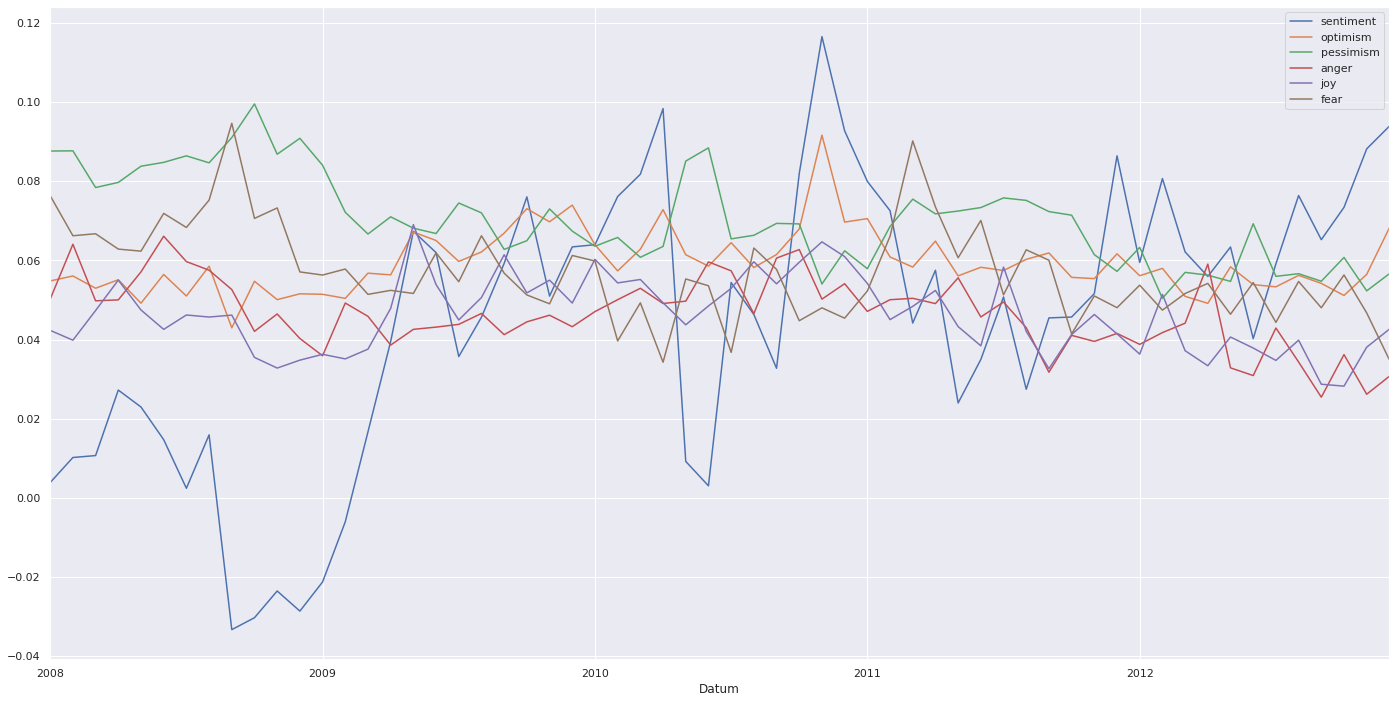

In [ ]:
# sentiment, optimism, pessimism, anger, joy, fear (2008-2012)
start_day = '01.01.2008'
end_day = '31.12.2012'

# Convert start / end dates to datetime
start_day = pd.to_datetime(start_day)
end_day = pd.to_datetime(end_day)


df_monthly_2008_2012 = df.loc[(df['date'] > start_day) & (df['date'] <= end_day)]
df_monthly_2008_2012 = df_monthly_2008_2012.resample('M', on='date').mean()
df_monthly_2008_2012 = df_monthly_2008_2012[['sentiment', 'optimism', 'pessimism', 'anger', 'joy', 'fear']]

df_monthly_2008_2012['sentiment'] = df_monthly_2008_2012['sentiment'].apply(lambda x: x*0.728975+0.05)
df_monthly_2008_2012['optimism'] = df_monthly_2008_2012['optimism'].apply(lambda x: x*0.8365532)
df_monthly_2008_2012['pessimism'] = df_monthly_2008_2012['pessimism'].apply(lambda x: x*0.964137)
df_monthly_2008_2012['anger'] = df_monthly_2008_2012['anger'].apply(lambda x: x*10)
df_monthly_2008_2012['joy'] = df_monthly_2008_2012['joy'].apply(lambda x: x*10)
df_monthly_2008_2012['fear'] = df_monthly_2008_2012['fear'].apply(lambda x: x*10)


df_monthly_2008_2012.plot(figsize=(24, 12))
plt.xlabel('Datum')

Text(0.5, 0, 'Datum')

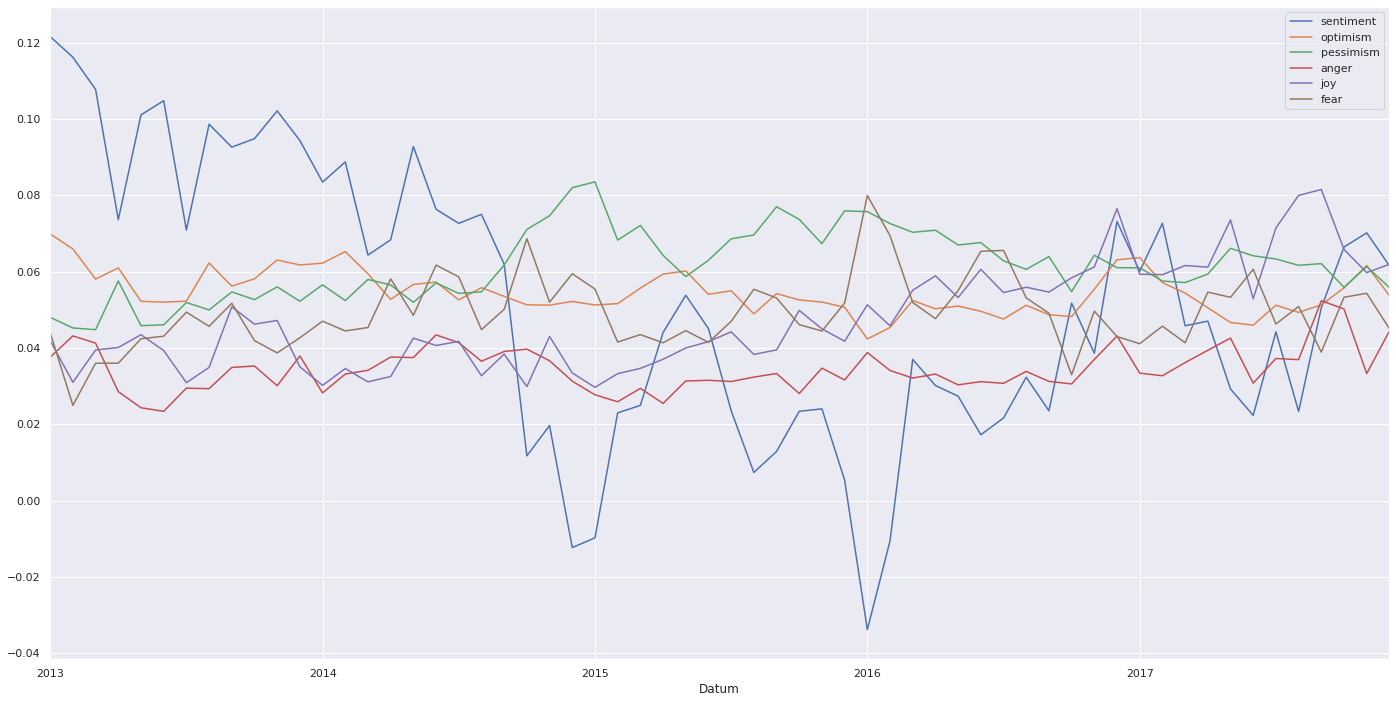

In [ ]:
# sentiment, optimism, pessimism, anger, joy, fear (2013-2017)
start_day = '01.01.2013'
end_day = '31.12.2017'

# Convert start / end dates to datetime
start_day = pd.to_datetime(start_day)
end_day = pd.to_datetime(end_day)


df_monthly_2013_2017 = df.loc[(df['date'] > start_day) & (df['date'] <= end_day)]
df_monthly_2013_2017 = df_monthly_2013_2017.resample('M', on='date').mean()
df_monthly_2013_2017 = df_monthly_2013_2017[['sentiment', 'optimism', 'pessimism', 'anger', 'joy', 'fear']]

df_monthly_2013_2017['sentiment'] = df_monthly_2013_2017['sentiment'].apply(lambda x: x*0.728975+0.05)
df_monthly_2013_2017['optimism'] = df_monthly_2013_2017['optimism'].apply(lambda x: x*0.8365532)
df_monthly_2013_2017['pessimism'] = df_monthly_2013_2017['pessimism'].apply(lambda x: x*0.964137)
df_monthly_2013_2017['anger'] = df_monthly_2013_2017['anger'].apply(lambda x: x*10)
df_monthly_2013_2017['joy'] = df_monthly_2013_2017['joy'].apply(lambda x: x*10)
df_monthly_2013_2017['fear'] = df_monthly_2013_2017['fear'].apply(lambda x: x*10)


df_monthly_2013_2017.plot(figsize=(24, 12))
plt.xlabel('Datum')

Text(0.5, 0, 'Datum')

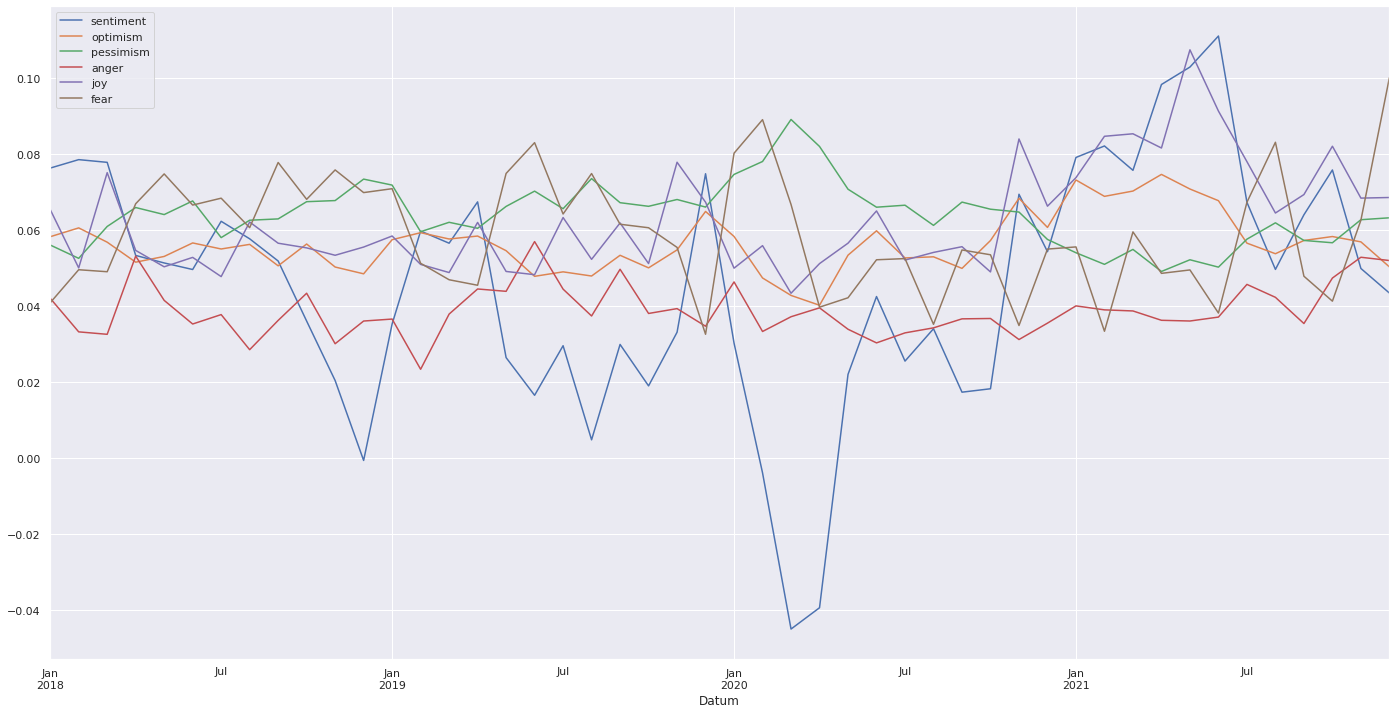

In [ ]:
# sentiment, optimism, pessimism, anger, joy, fear (2018-2021)
start_day = '01.01.2018'
end_day = '31.12.2021'

# Convert start / end dates to datetime
start_day = pd.to_datetime(start_day)
end_day = pd.to_datetime(end_day)


df_monthly_2018_2021 = df.loc[(df['date'] > start_day) & (df['date'] <= end_day)]
df_monthly_2018_2021 = df_monthly_2018_2021.resample('M', on='date').mean()
df_monthly_2018_2021 = df_monthly_2018_2021[['sentiment', 'optimism', 'pessimism', 'anger', 'joy', 'fear']]

df_monthly_2018_2021['sentiment'] = df_monthly_2018_2021['sentiment'].apply(lambda x: x*0.728975+0.05)
df_monthly_2018_2021['optimism'] = df_monthly_2018_2021['optimism'].apply(lambda x: x*0.8365532)
df_monthly_2018_2021['pessimism'] = df_monthly_2018_2021['pessimism'].apply(lambda x: x*0.964137)
df_monthly_2018_2021['anger'] = df_monthly_2018_2021['anger'].apply(lambda x: x*10)
df_monthly_2018_2021['joy'] = df_monthly_2018_2021['joy'].apply(lambda x: x*10)
df_monthly_2018_2021['fear'] = df_monthly_2018_2021['fear'].apply(lambda x: x*10)


df_monthly_2018_2021.plot(figsize=(24, 12))
plt.xlabel('Datum')

Text(0, 0.5, 'Ölpreis')

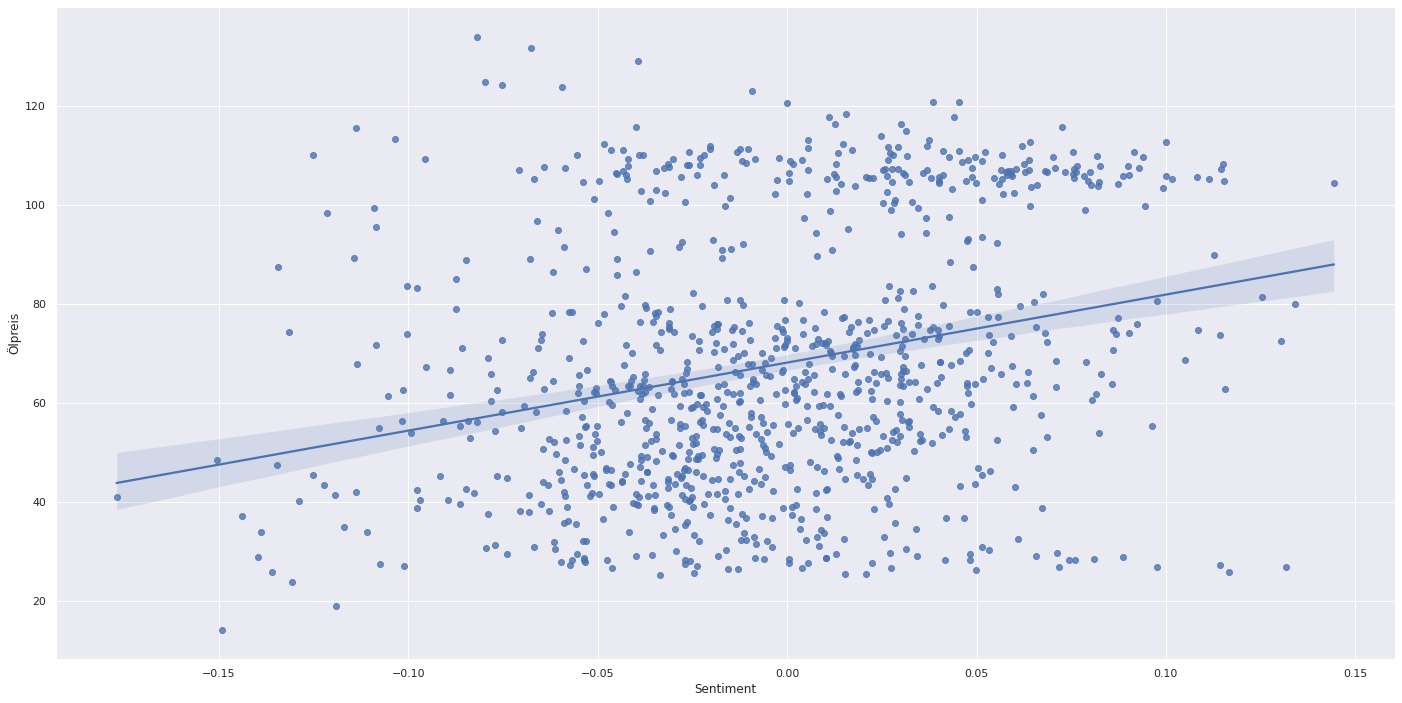

In [ ]:
# linear regression for sentiment and price (weekly interval)
# https://seaborn.pydata.org/tutorial/regression.html
plt.figure(figsize=(24, 12))
sns.regplot(x="sentiment", y="price", data=df_weekly);
plt.xlabel('Sentiment')
plt.ylabel('Ölpreis')

Text(0, 0.5, 'Ölpreis')

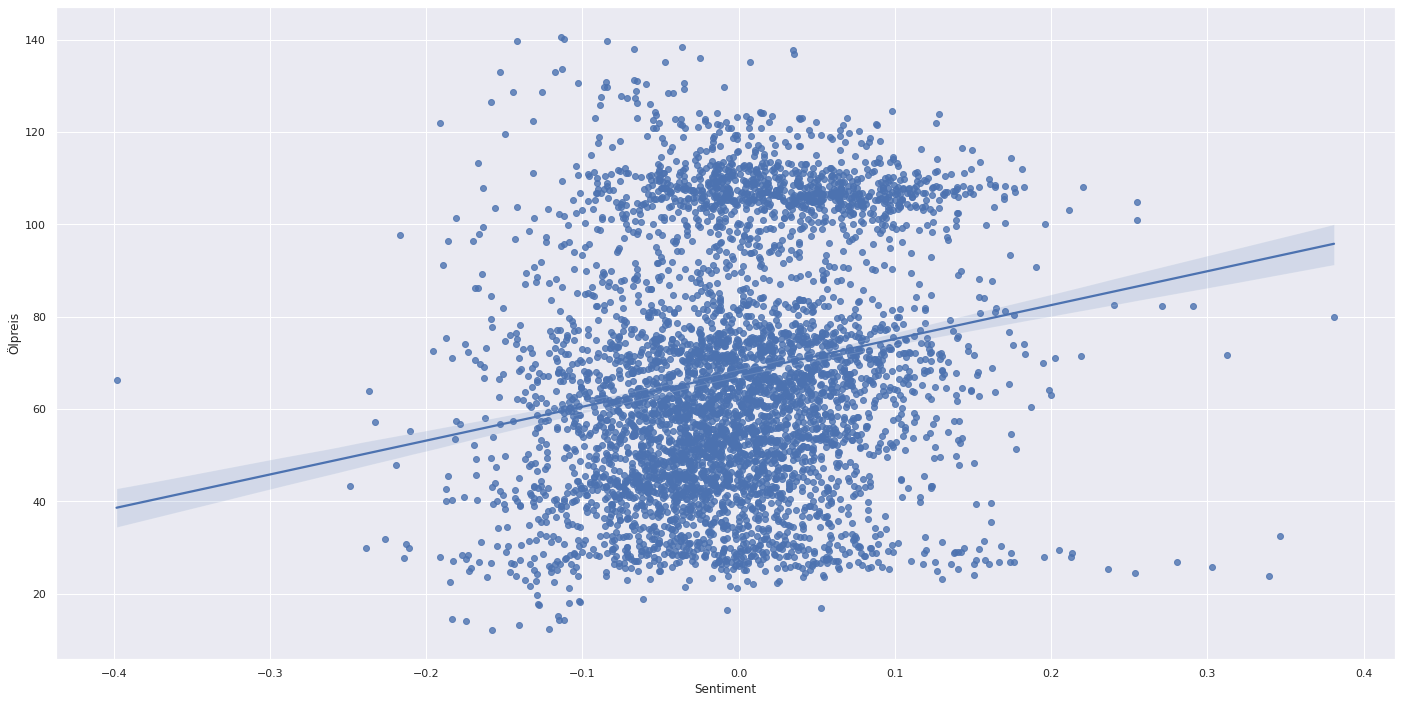

In [ ]:
# linear regression for sentiment and price (daily interval)
# https://seaborn.pydata.org/tutorial/regression.html
plt.figure(figsize=(24, 12))
sns.regplot(x="sentiment", y="price", data=df);
plt.xlabel('Sentiment')
plt.ylabel('Ölpreis')

Text(0, 0.5, 'Ölpreis')

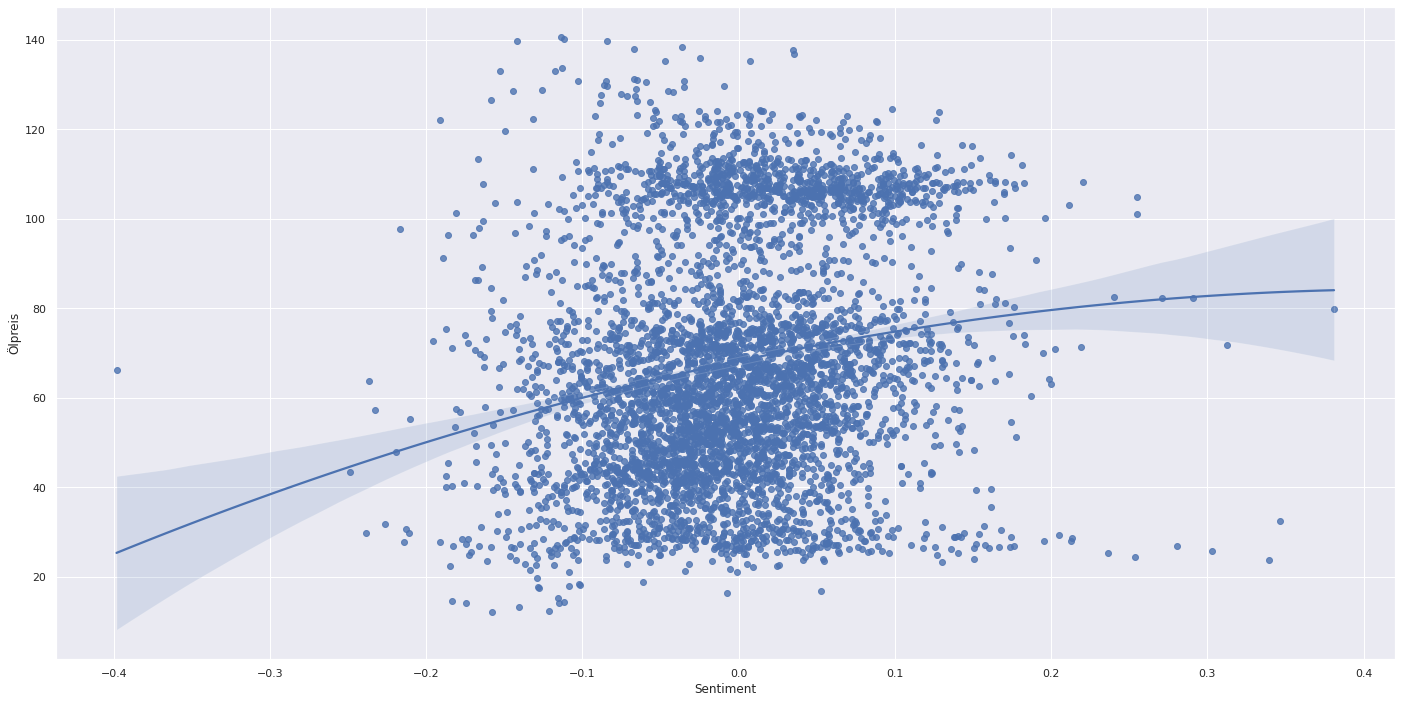

In [ ]:
# polynomial regression with order 2 for sentiment and price
plt.figure(figsize=(24, 12))
sns.regplot(x="sentiment", y="price", data=df, order=2)
plt.xlabel('Sentiment')
plt.ylabel('Ölpreis')